# ANES

Intro...

[Ryan Burge has done a similar analysis]() with data from the [Cooperative Election Study](https://cces.gov.harvard.edu/) (CSE)...

In [52]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/examples/anes_2024_pilot.ipynb) -- but you will have to download the data yourself, because I am not allowed to redistribute it.

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [54]:
from statsmodels.nonparametric.smoothers_lowess import lowess


def make_lowess(series, frac=0.5):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x, frac=frac)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

<IPython.core.display.Javascript object>

In [55]:
def plot_series_lowess(series, color, plot_series=True, frac=0.5, **options):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    if "label" not in options:
        options["label"] = series.name

    if plot_series or len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.3, label="_")

    if not plot_series and len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.6, label=options["label"])

    if len(series) > 1:
        smooth = make_lowess(series, frac=frac)
        smooth.plot(color=color, **options)

<IPython.core.display.Javascript object>

In [56]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

<IPython.core.display.Javascript object>

In [57]:
def values(series):
    return series.value_counts(dropna=False).sort_index()

<IPython.core.display.Javascript object>

## Read the Data

In [58]:
from os.path import basename, exists
from pathlib import Path


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

<IPython.core.display.Javascript object>

[You can get the data here](https://electionstudies.org/data-center/2024-pilot-study/) -- but you'll need to create an account.

In [59]:
def decorate_plot(title):
    decorate(xlabel="Year", ylabel="% liberal - % conservative", title=title)

<IPython.core.display.Javascript object>

## Make the plot with all respondents


In [60]:
def savefig(filename, **options):
    if "dpi" not in options:
        options["dpi"] = 300
    plt.savefig(filename, **options)

<IPython.core.display.Javascript object>

In [61]:
def resample_rows_weighted(df, column):
    """Resamples a DataFrame using probabilities proportional to given column.

    df: DataFrame
    column: string column name to use as weights

    returns: DataFrame
    """
    weights = df[column]
    sample = df.sample(n=len(df), replace=True, weights=weights)
    return sample

<IPython.core.display.Javascript object>

In [62]:
def resample_diffs_smooth(df, query, iters=101):
    diffs = []
    for i in range(iters):
        sample = resample_by_year(df, "wtsamp").query(query)
        diff = make_diff(sample)
        smooth = make_lowess(diff)
        diffs.append(smooth)
    return diffs

<IPython.core.display.Javascript object>

In [63]:
filename = "anes_pilot_2024_20240319.dta"
df = pd.read_stata(filename, convert_categoricals=False)
df.shape

(1909, 941)

<IPython.core.display.Javascript object>

In [64]:
df.columns.values

array(['version', 'caseid', 'weight', 'weight_spss', 'sample_type',
       'duration', 'min_duration', 'status_work', 'status_catwork',
       'status_catrecent', 'empsat_satisf', 'empcareer_career',
       'empcareer_careerstr', 'empsuperv_superv', 'empsuperv_selfsuperv',
       'emploss_losejob', 'emploss_less', 'emploss_ai', 'emploss_robot',
       'secure_ease', 'secure_parents', 'infl_behav_1', 'infl_behav_2',
       'infl_behav_3', 'infl_behav_4', 'infl_behav_5',
       'follow_campinterest', 'partic_vote', 'partic_protest',
       'poldisc_socmed_1', 'poldisc_socmed_2', 'poldisc_socmed_3',
       'poldisc_socmed_4', 'poldisc_socmed_5', 'poldisc_socmed_6',
       'poldisc_socmed_7', 'poldisc_socmed_8', 'poldisc_socmed_9',
       'poldisc_socmed_10', 'poldisc_socmed_t', 'poldisc_smpol',
       'poldisc_peoplekn', 'poldisc_intldisc', 'mobil_talk',
       'mobil_online', 'mobil_rally', 'mobil_button', 'mobil_work',
       'contrib_donate', 'contrib_party', 'contrib_party_t',
       

<IPython.core.display.Javascript object>

In [65]:
from utils import underride


def value_counts(series, **options):
    """Make a series of values and the number of times they appear.

    Returns a DataFrame because they get rendered better in Jupyter.

    series: Pandas Series

    returns: Pandas DataFrame
    """
    options = underride(options, dropna=False)
    series = series.value_counts(**options).sort_index()
    series.index.name = "values"
    series.name = "counts"
    return pd.DataFrame(series)

<IPython.core.display.Javascript object>

In [66]:
value_counts(df["gender"])

,counts
values,
1.0,877
2.0,1032


<IPython.core.display.Javascript object>

In [67]:
df["age"] = df["age"].replace(-9, np.nan)
value_counts(df["age"])

,counts
values,
18.0,11
19.0,14
20.0,46
21.0,27
22.0,36
...,...
86.0,1
88.0,3
90.0,1


<IPython.core.display.Javascript object>

In [68]:
df["weight"].describe()

count    1500.000000
mean        1.000000
std         0.468987
min         0.314350
25%         0.718226
50%         0.894765
75%         1.130104
max         7.000960
Name: weight, dtype: float64

<IPython.core.display.Javascript object>

In [69]:
varname = "follow_campinterest"
value_counts(df[varname])

,counts
values,
-1.0,133
1.0,728
2.0,651
3.0,397


<IPython.core.display.Javascript object>

In [70]:
sample = df.sample(len(df), replace=True, weights=df["weight"])

<IPython.core.display.Javascript object>

In [71]:
df_male = sample.query("gender == 1")
df_female = sample.query("gender == 2")
len(df_male), len(df_female)

(905, 1004)

<IPython.core.display.Javascript object>

In [72]:
df.columns.values

array(['version', 'caseid', 'weight', 'weight_spss', 'sample_type',
       'duration', 'min_duration', 'status_work', 'status_catwork',
       'status_catrecent', 'empsat_satisf', 'empcareer_career',
       'empcareer_careerstr', 'empsuperv_superv', 'empsuperv_selfsuperv',
       'emploss_losejob', 'emploss_less', 'emploss_ai', 'emploss_robot',
       'secure_ease', 'secure_parents', 'infl_behav_1', 'infl_behav_2',
       'infl_behav_3', 'infl_behav_4', 'infl_behav_5',
       'follow_campinterest', 'partic_vote', 'partic_protest',
       'poldisc_socmed_1', 'poldisc_socmed_2', 'poldisc_socmed_3',
       'poldisc_socmed_4', 'poldisc_socmed_5', 'poldisc_socmed_6',
       'poldisc_socmed_7', 'poldisc_socmed_8', 'poldisc_socmed_9',
       'poldisc_socmed_10', 'poldisc_socmed_t', 'poldisc_smpol',
       'poldisc_peoplekn', 'poldisc_intldisc', 'mobil_talk',
       'mobil_online', 'mobil_rally', 'mobil_button', 'mobil_work',
       'contrib_donate', 'contrib_party', 'contrib_party_t',
       

<IPython.core.display.Javascript object>

In [73]:
value_counts(df["gender"])

,counts
values,
1.0,877
2.0,1032


<IPython.core.display.Javascript object>

In [74]:
df["age"] = df["age"].replace(-9, np.nan)
value_counts(df["age"])

,counts
values,
18.0,11
19.0,14
20.0,46
21.0,27
22.0,36
...,...
86.0,1
88.0,3
90.0,1


<IPython.core.display.Javascript object>

In [75]:
df["weight"].describe()

count    1500.000000
mean        1.000000
std         0.468987
min         0.314350
25%         0.718226
50%         0.894765
75%         1.130104
max         7.000960
Name: weight, dtype: float64

<IPython.core.display.Javascript object>

In [76]:
varname = "follow_campinterest"
value_counts(df[varname])

,counts
values,
-1.0,133
1.0,728
2.0,651
3.0,397


<IPython.core.display.Javascript object>

In [77]:
sample = df.sample(len(df), replace=True, weights=df["weight"])

<IPython.core.display.Javascript object>

In [127]:
sample_male = sample.query("gender == 1").copy()
sample_female = sample.query("gender == 2").copy()
len(sample_male), len(sample_female)

(928, 981)

<IPython.core.display.Javascript object>

In [128]:
def find_columns(df, prefix):
    return [
        col
        for col in df.columns
        if col.startswith(prefix)
        and not col.endswith("skp")
        and not col.endswith("timing")
    ]

<IPython.core.display.Javascript object>

## How important

How important are each of the following issues in the country today?

In [217]:
columns = find_columns(sample, "imp_")
columns

['imp_immig',
 'imp_jobs',
 'imp_costliv',
 'imp_climate',
 'imp_abort',
 'imp_gun',
 'imp_crime',
 'imp_gaza',
 'imp_antisem',
 'imp_votright',
 'imp_ukraine',
 'imp_schteach',
 'imp_islamop']

<IPython.core.display.Javascript object>

In [225]:
def normalized_counts(data, columns):
    return pd.DataFrame(
        {col: data[col].value_counts(normalize=True) for col in columns}
    ).fillna(0)

<IPython.core.display.Javascript object>

In [252]:
def count_responses(data, columns, slice_map):
    counts = normalized_counts(data, columns)

    d = {key: counts.loc[slice1].sum() for key, slice1 in slice_map.items()}

    return pd.DataFrame(d)

<IPython.core.display.Javascript object>

In [253]:
def summarize_responses(columns, slice_map):
    summary_male = count_responses(data_male, columns, slice_map)
    summary_female = count_responses(data_female, columns, slice_map)

    summary = (
        pd.concat(
            [summary_male, summary_female], axis=1, keys=["male", "female"]
        ).sort_values(by=("female", "important"))
        * 100
    )

    return summary

<IPython.core.display.Javascript object>

In [254]:
def draw_markers(summary, group, response):
    markers = dict(male="s", female="o")
    colors = dict(male="C0", female="C1")
    alphas = dict(important=0.9, not_important=0.5)
    x = summary[group, response]
    plt.plot(
        x,
        names,
        markers[group],
        color=colors[group],
        alpha=alphas[response],
        label=f"{group}, {response}",
    )

<IPython.core.display.Javascript object>

In [255]:
def plot_responses(summary, response):
    plt.hlines(
        names,
        summary["male", response],
        summary["female", response],
        color="gray",
        alpha=0.2,
    )

    draw_markers(summary, "male", response)
    draw_markers(summary, "female", response)

<IPython.core.display.Javascript object>

In [256]:
issue_names = {
    "imp_immig": "Illegal immigration",
    "imp_jobs": "Jobs/employment",
    "imp_costliv": "Cost of living and\nrising prices",
    "imp_climate": "Climate change",
    "imp_abort": "Abortion",
    "imp_gun": "Gun policy",
    "imp_crime": "Crime",
    "imp_gaza": "War in Gaza",
    "imp_antisem": "Antisemitism",
    "imp_votright": "Voting rights",
    "imp_ukraine": "War in Ukraine",
    "imp_schteach": "What’s taught in\npublic schools",
    "imp_islamop": "Anti-Muslim bias",
}

<IPython.core.display.Javascript object>

In [257]:
columns = issue_names.keys()
counts = normalized_counts(sample, columns)
counts

,imp_immig,imp_jobs,imp_costliv,imp_climate,imp_abort,imp_gun,imp_crime,imp_gaza,imp_antisem,imp_votright,imp_ukraine,imp_schteach,imp_islamop
-7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001572,0.000000,0.000000
1.0,0.460974,0.455212,0.652174,0.328444,0.374542,0.420115,0.451545,0.203772,0.213201,0.438973,0.197486,0.416972,0.154007
2.0,0.216344,0.334206,0.223677,0.194866,0.259298,0.293871,0.294919,0.269775,0.287061,0.286537,0.281299,0.331063,0.198533
3.0,0.171294,0.168151,0.105815,0.178628,0.190152,0.165008,0.182294,0.278680,0.262965,0.164484,0.257203,0.171294,0.281299
4.0,0.109481,0.030382,0.013096,0.105815,0.078051,0.068098,0.064955,0.138816,0.127816,0.056574,0.136197,0.055526,0.166579
5.0,0.041907,0.012048,0.005238,0.192247,0.097957,0.052907,0.006286,0.108958,0.108958,0.053431,0.126244,0.025144,0.199581


<IPython.core.display.Javascript object>

In [258]:
data_male = sample_male[columns].replace(-7, np.nan)
data_female = sample_female[columns].replace(-7, np.nan)

<IPython.core.display.Javascript object>

In [263]:
slice_map = dict(important=slice(1, 2), not_important=slice(4, 5))
summary = summarize_responses(columns, slice_map)
summary

male                   female              
              important not_important  important not_important
imp_islamop   35.991379     40.517241  34.556575     32.925586
imp_gaza      47.090517     26.293103  47.604485     23.343527
imp_ukraine   46.270270     26.054054  49.541284     26.503568
imp_climate   53.987069     30.711207  50.764526     28.950051
imp_antisem   48.814655     26.616379  51.172273     20.897044
imp_immig     68.426724     15.193966  67.074414     15.086646
imp_abort     58.512931     20.689655  67.991845     14.678899
imp_gun       71.443966     13.362069  71.355759     10.907238
imp_votright  73.491379     12.068966  71.661570      9.989806
imp_schteach  71.875000     10.775862  77.573904      5.504587
imp_crime     71.228448      8.620690  77.879715      5.708461
imp_jobs      78.556034      3.879310  79.306830      4.587156
imp_costliv   85.883621      2.262931  89.194699      1.427115

<IPython.core.display.Javascript object>

In [264]:
names = [issue_names[col] for col in summary.index]

<IPython.core.display.Javascript object>

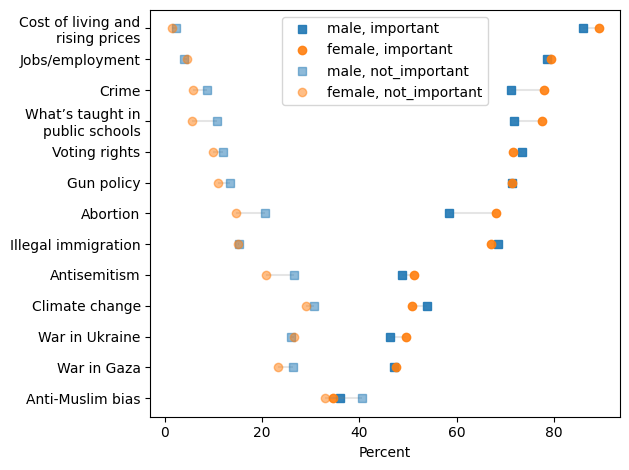

<IPython.core.display.Javascript object>

In [265]:
plot_responses(summary, "important")
plot_responses(summary, "not_important")
decorate(xlabel="Percent")

## Which Party Better Job

Please tell us which political
party— the [Democrats/Republicans] or the [Republicans/Democrats]—would do a
better job handling each of the following issues, or is there no difference.

In [237]:
columns = find_columns(sample, "own_")

<IPython.core.display.Javascript object>

In [238]:
issue_names = {
    "own_immig": "Illegal immigration",
    "own_jobs": "Jobs/employment",
    "own_costliv": "Cost of living and\nrising prices",
    "own_climate": "Climate change",
    "own_abort": "Abortion",
    "own_gun": "Gun policy",
    "own_crime": "Crime",
    "own_gaza": "War in Gaza",
    "own_antisem": "Antisemitism",
    "own_votright": "Voting rights",
    "own_ukraine": "War in Ukraine",
    "own_schteach": "What’s taught in\npublic schools",
    "own_islamop": "Anti-Muslim bias",
}

<IPython.core.display.Javascript object>

In [239]:
columns = issue_names.keys()
counts = normalized_counts(sample, columns)
counts

,own_immig,own_jobs,own_costliv,own_climate,own_abort,own_gun,own_crime,own_gaza,own_antisem,own_votright,own_ukraine,own_schteach,own_islamop
-7.0,0.000000,0.000000,0.000000,0.000000,0.001048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000524,0.000000,0.000000
1.0,0.304872,0.360398,0.316920,0.434259,0.454164,0.383971,0.267156,0.274489,0.308539,0.419591,0.347302,0.371399,0.353588
2.0,0.432163,0.373494,0.377161,0.219487,0.287061,0.372970,0.379256,0.297538,0.248298,0.280775,0.281823,0.338921,0.195914
3.0,0.262965,0.266108,0.305919,0.346255,0.257727,0.243059,0.353588,0.427973,0.443164,0.299633,0.370351,0.289680,0.450498


<IPython.core.display.Javascript object>

In [240]:
data_male = sample_male[columns].replace(-7, np.nan)
data_female = sample_female[columns].replace(-7, np.nan)

<IPython.core.display.Javascript object>

In [241]:
slice_map = dict(important=slice(1, 1), not_important=slice(2, 2))
summary = summarize_responses(slice_map)
summary

male                   female              
              important not_important  important not_important
own_crime     28.663793     39.547414  24.872579     36.391437
own_gaza      28.987069     31.465517  25.993884     28.134557
own_immig     32.435345     45.474138  28.644241     41.080530
own_antisem   32.758621     28.340517  29.051988     21.508665
own_costliv   33.836207     39.224138  29.663609     36.289501
own_ukraine   39.331897     31.465517  30.408163     25.102041
own_jobs      39.870690     39.870690  32.415902     34.964322
own_islamop   38.146552     22.844828  32.721713     16.513761
own_schteach  39.762931     36.637931  34.658512     31.294597
own_votright  46.982759     29.849138  37.206932     26.401631
own_gun       39.224138     40.086207  37.614679     34.658512
own_climate   48.383621     25.538793  38.735984     18.552497
own_abort     47.300216     30.993521  43.730887     26.605505

<IPython.core.display.Javascript object>

In [ ]:
names = [issue_names[col] for col in summary.index]

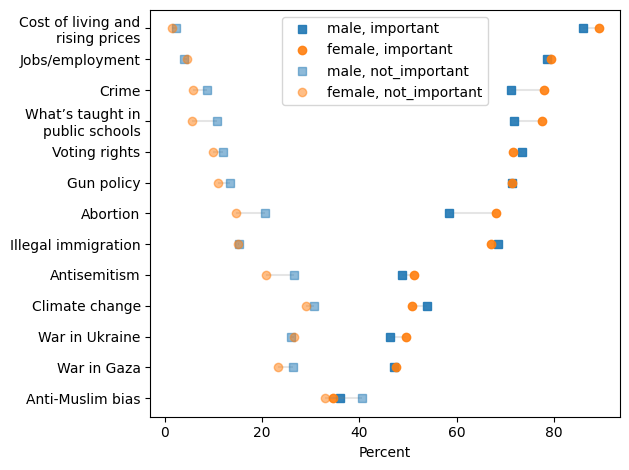

<IPython.core.display.Javascript object>

In [193]:
plot_responses(summary, "important")
plot_responses(summary, "not_important")
decorate(xlabel="Percent")

## Look for variables with large gender gaps

In [27]:
def compute_diff(col, flag):
    male = df_male[col].dropna().value_counts()
    female = df_female[col].dropna().value_counts()
    if len(male) == 0 or len(female) == 0:
        return np.nan
    
    if flag:
        value = male.idxmax()
    else:
        value = female.idxmax()
        
    p_male = male.get(value, np.nan) / male.sum()
    p_female = female.get(value, np.nan) / female.sum()
    return p_male - p_female

In [28]:
res = []
for col in df.columns:
    diff1 = compute_diff(col, True)
    diff2 = compute_diff(col, False)
    res.append((col, diff1, diff2))

In [29]:
columns = ["varname", "diff1", 'diff2']
diff_df = pd.DataFrame(res, columns=columns).dropna()

In [30]:
diff1 = diff_df['diff1']
diff2 = diff_df['diff2']
diff_df['absdiff'] = np.maximum(diff_df['diff1'].abs(), diff_df['diff2'].abs())

In [31]:
candidates = (
    diff_df.sort_values(by="absdiff", ascending=False)
)
candidates.index = candidates['varname']
candidates = candidates.drop(columns=['varname']) * 100
candidates.head(50)

,diff1,diff2,absdiff
varname,,,
gender4,96.845069,-96.340486,96.845069
gendid_masc,33.375336,-45.865320,45.865320
gendid_fem,43.910543,-33.239120,43.910543
gendid_mascfem,39.178640,-38.053565,39.178640
newsint,16.946710,16.946710,16.946710
follow_campinterest,16.614127,-0.053565,16.614127
own_ukraine,9.122661,-15.654794,15.654794
own_climate,5.539213,-14.534438,14.534438
aid_israel,-14.269030,-14.269030,14.269030


In [32]:
candidates.to_csv('anes_2024_candidates_resampled.csv')

In [33]:
def compare_responses(varname):
    d = dict(male=value_counts(df_male[varname], normalize=True)['counts'],
             female=value_counts(df_female[varname], normalize=True)['counts'])
    summary = pd.DataFrame(d)
    summary['diff'] = summary['male'] - summary['female']
    summary['absdiff'] = summary['diff'].abs()
    return summary

In [34]:
compare_responses('pew_prayer') * 100

,male,female,diff,absdiff
values,,,,
1.0,19.789474,30.656934,-10.867461,10.867461
2.0,14.105263,15.328467,-1.223204,1.223204
3.0,14.315789,10.218978,4.096811,4.096811
4.0,5.578947,1.876955,3.701992,3.701992
5.0,6.421053,5.839416,0.581637,0.581637
6.0,12.315789,15.432742,-3.116953,3.116953
7.0,23.157895,17.726799,5.431096,5.431096
8.0,4.315789,2.919708,1.396081,1.396081


In [35]:
def compute_diff(col, flag):
    male = df_male[col].dropna().value_counts()
    female = df_female[col].dropna().value_counts()
    if len(male) == 0 or len(female) == 0:
        return np.nan
    
    if flag:
        value = male.idxmax()
    else:
        value = female.idxmax()
        
    p_male = male.get(value, np.nan) / male.sum()
    p_female = female.get(value, np.nan) / female.sum()
    return p_male - p_female

In [36]:
res = []
for col in df.columns:
    diff1 = compute_diff(col, True)
    diff2 = compute_diff(col, False)
    res.append((col, diff1, diff2))

In [37]:
columns = ["varname", "diff1", 'diff2']
diff_df = pd.DataFrame(res, columns=columns).dropna()

In [38]:
diff1 = diff_df['diff1']
diff2 = diff_df['diff2']
diff_df['absdiff'] = np.maximum(diff_df['diff1'].abs(), diff_df['diff2'].abs())

In [39]:
candidates = (
    diff_df.sort_values(by="absdiff", ascending=False)
)
candidates.index = candidates['varname']
candidates = candidates.drop(columns=['varname']) * 100
candidates.head(50)

,diff1,diff2,absdiff
varname,,,
gender4,96.845069,-96.340486,96.845069
gendid_masc,33.375336,-45.865320,45.865320
gendid_fem,43.910543,-33.239120,43.910543
gendid_mascfem,39.178640,-38.053565,39.178640
newsint,16.946710,16.946710,16.946710
follow_campinterest,16.614127,-0.053565,16.614127
own_ukraine,9.122661,-15.654794,15.654794
own_climate,5.539213,-14.534438,14.534438
aid_israel,-14.269030,-14.269030,14.269030


In [40]:
candidates.to_csv('anes_2024_candidates_resampled.csv')

In [41]:
def compare_responses(varname):
    d = dict(male=value_counts(df_male[varname], normalize=True)['counts'],
             female=value_counts(df_female[varname], normalize=True)['counts'])
    summary = pd.DataFrame(d)
    summary['diff'] = summary['male'] - summary['female']
    summary['absdiff'] = summary['diff'].abs()
    return summary

In [42]:
compare_responses('pew_prayer') * 100

,male,female,diff,absdiff
values,,,,
1.0,19.789474,30.656934,-10.867461,10.867461
2.0,14.105263,15.328467,-1.223204,1.223204
3.0,14.315789,10.218978,4.096811,4.096811
4.0,5.578947,1.876955,3.701992,3.701992
5.0,6.421053,5.839416,0.581637,0.581637
6.0,12.315789,15.432742,-3.116953,3.116953
7.0,23.157895,17.726799,5.431096,5.431096
8.0,4.315789,2.919708,1.396081,1.396081
